In [102]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.formula.api as sfa
from statsmodels.iolib.summary2 import summary_col
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

# 1

# 1.1

In [2]:
# Load the data and check out the key variables
rem = pd.read_csv("https://raw.githubusercontent.com/kyleco/kyleco.github.io/master/data/analysis_dataallcountries.csv")

# We see that 55% of clients reached the goal and 61% received the reminder treatment.
print(rem[['reached_b4goal', 'rem_any']].mean())

reached_b4goal    0.553319
rem_any           0.611578
dtype: float64


In [3]:
# Set up our variables
randfeature = "highint rewardint joint dc joint_single"
covariates = "female  highschool_completed married inc_7d wealthy hyperbolic spent_b4isaved saved_asmuch missing_female missing_age missing_highschool_completed missing_married missing_saved_asmuch missing_spent_b4isaved"

Xrandfeature = "+".join(randfeature.split())
Xfull = "+".join(randfeature.split() + covariates.split())

# NOTE: In a LPM in Statsmodels the outcome has to be a float!
# It will complain if this is an int!
rem['reached_b4goal'] = rem['reached_b4goal'].astype('float')
rem['female'] = rem['female'].astype('float')



formula_col3 = "reached_b4goal ~ rem_any + {Xs} + C(country)".format(Xs=Xrandfeature)
r_col3 = sfa.ols(formula_col3, data=rem).fit(cov_type='HC1')

formula_col4 = "reached_b4goal ~ rem_any + {Xs} + C(depart) + C(provincia) + C(marketer) + C(branch) + C(country)".format(Xs=Xfull)
r_col4 = sfa.ols(formula_col4, data=rem).fit(cov_type='HC1')

# Let's do a really simple model with only country dummies as controls
formula_simple = "reached_b4goal ~ rem_any + C(country)"
r_simple = sfa.ols(formula_simple, data=rem).fit(cov_type='HC1')

# Simplest possible model. Bivariate!
formula_biv = "reached_b4goal ~ rem_any"
r_biv = sfa.ols(formula_biv, data=rem).fit(cov_type='HC1')

/home/aboli/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [4]:
print(r_col3.summary(),'\n', r_col4.summary())

                            OLS Regression Results                            
Dep. Variable:         reached_b4goal   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     163.4
Date:                Thu, 13 Feb 2020   Prob (F-statistic):          3.20e-264
Time:                        16:42:12   Log-Likelihood:                -9293.0
No. Observations:               13560   AIC:                         1.860e+04
Df Residuals:                   13551   BIC:                         1.867e+04
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6628      0.012     

/home/aboli/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 60, but rank is 52
  'rank is %d' % (J, J_), ValueWarning)


In [5]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:0.4f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}",
           'No. coefficients': lambda x: f"{x.params.shape[0]}"
          }

results_table = summary_col(results=[r_col3, r_col4],
                            float_format='%0.6f',
                            stars = True,
                            model_names=[
                                'Column 3\n(in paper)',
                                'Column 4\n(in paper)'
                            ],
                            info_dict=info_dict,
                            regressor_order=['rem_any'],
                            drop_omitted=True)

print("Reproducing table 4 in Karlan et al. 2016")
print(results_table)

Reproducing table 4 in Karlan et al. 2016

                   Column 3    Column 4 
                  (in paper)  (in paper)
----------------------------------------
rem_any          0.031855*** 0.031861***
                 (0.009153)  (0.008950) 
R-squared        0.0671      0.1082     
No. observations 13560       13560      
No. coefficients 9           61         
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# 2

In [54]:
# This cell contains the "data-generating process."
# We will make it up, but try to create something close to
# what we saw in the Karlan experiment above.
# That will help us get a better sense of how the regression is behaving.

# Set the same size like the real data.
N = 13560

# Our "control variable" will be an indicator for graduating from high-school.
grad_high_school = np.random.binomial(n=1, p=0.5, size=N)
beta_hs = 0.1


# Set the data-generating process to have on average
# 61% of people in the treatment group, like in the paper.
# Set the ATE to be 0.032, similar to what we see in the real data.
D = np.random.binomial(n=1, p=0.61, size=N)
ATE = 0.032

# Generate the potential outcomes.
# We have to be careful tha the probabilities remain in the valid
# range [0, 1] or else we will get an error.
baseline_probability = 0.25 + beta_hs * grad_high_school
Y0 = np.random.binomial(n=1, p=baseline_probability)
Y1 = np.random.binomial(n=1, p=baseline_probability + ATE * D)

df = pd.DataFrame({
    'grad_high_school': grad_high_school,
    'd': D,
    'y0': Y0,
    'y1': Y1
})
df['y'] = df.eval("y1 * d + y0 * (1 - d)")
print(df.mean())

grad_high_school    0.497935
d                   0.611799
y0                  0.300074
y1                  0.323378
y                   0.321608
dtype: float64


In [55]:
# This cells fits two different models. 
# One model has the control variable and the other doesn't.

# We call this model a bivariate one
# because it is just a relationship between two variables.
r_sim_biv = sfa.ols("y ~ d", df).fit()

# This model is more complex because it has an additional covariate
# (aka control variable).
r_sim_control = sfa.ols("y ~ d + grad_high_school", df).fit()


info_dict={'R-squared' : lambda x: f"{x.rsquared:0.4f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}",
           'No. coefficients': lambda x: f"{x.params.shape[0]}"}

results_table = summary_col(results=[r_sim_biv, r_sim_control],
                            float_format='%0.4f',
                            stars = True,
                            model_names=[
                                'Model 1',
                                'Model 2',
                            ],
                            info_dict=info_dict,
                            regressor_order=['d', 'grad_high_school'],
                            drop_omitted=True)

print(results_table)


                  Model 1   Model 2 
------------------------------------
d                0.0394*** 0.0398***
                 (0.0082)  (0.0082) 
grad_high_school           0.1006***
                           (0.0080) 
R-squared        0.0017    0.0133   
No. observations 13560     13560    
No. coefficients 2         3        
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# 4.

In [86]:
def Model_fit(N = 13560, beta_hs = 0.35, ATE = 0.032):
    params = locals().copy()
  # Set the same size like the real data.

    # Our "control variable" will be an indicator for graduating from high-school.
    grad_high_school = np.random.binomial(n=1, p=0.5, size=N)
    


    # Set the data-generating process to have on average
    # 61% of people in the treatment group, like in the paper.
    # Set the ATE to be 0.032, similar to what we see in the real data.
    D = np.random.binomial(n=1, p=0.61, size=N)
    
    # Generate the potential outcomes.
    # We have to be careful tha the probabilities remain in the valid
    # range [0, 1] or else we will get an error.
    baseline_probability = 0.25 + beta_hs * grad_high_school
    Y0 = np.random.binomial(n=1, p=baseline_probability)
    Y1 = np.random.binomial(n=1, p=baseline_probability + ATE * D)

    df = pd.DataFrame({
    'grad_high_school': grad_high_school,
    'd': D,
    'y0': Y0,
    'y1': Y1
    })
    df['y'] = df.eval("y1 * d + y0 * (1 - d)")
    
    # This cells fits two different models. 
    # One model has the control variable and the other doesn't.

    # We call this model a bivariate one
    # because it is just a relationship between two variables.
    Model1 = sfa.ols("y ~ d", df).fit()
    
    Model2 = sfa.ols("y ~ d + grad_high_school", df).fit()
    
    
    results_table = [dict({
      'Estimated coefficient of d': (result_reg.params['d']),
      'Standard Error in d': (result_reg.bse['d']),
      'P value': (result_reg.pvalues['d'])}, **params) for result_reg in (Model1, Model2)]
    

    return results_table



In [87]:
Model_fit()

[{'Estimated coefficient of d': 0.029251611645940135,
  'Standard Error in d': 0.008792829062800754,
  'P value': 0.0008809631689678,
  'N': 13560,
  'beta_hs': 0.35,
  'ATE': 0.032},
 {'Estimated coefficient of d': 0.026581936112003324,
  'Standard Error in d': 0.00827042804948169,
  'P value': 0.0013116292954794173,
  'N': 13560,
  'beta_hs': 0.35,
  'ATE': 0.032}]

In [88]:
B = 1000
Repeated_sampling_results_Model1 = pd.DataFrame([Model_fit(N=N)[0] for _ in np.arange(0, B)])
Repeated_sampling_results_Model2 = pd.DataFrame([Model_fit(N=N)[1] for _ in np.arange(0, B)])

In [89]:
Repeated_sampling_results_Model1.describe()

,Estimated coefficient of d,Standard Error in d,P value,N,beta_hs,ATE
count,1000.000000,1000.000000,1.000000e+03,1000.0,1.000000e+03,1.000000e+03
mean,0.031990,0.008745,1.061445e-02,13560.0,3.500000e-01,3.200000e-02
std,0.008667,0.000019,5.407759e-02,0.0,3.221258e-15,2.082710e-17
min,-0.000035,0.008684,6.401579e-14,13560.0,3.500000e-01,3.200000e-02
25%,0.026549,0.008732,1.742314e-05,13560.0,3.500000e-01,3.200000e-02
50%,0.032326,0.008744,2.184588e-04,13560.0,3.500000e-01,3.200000e-02
75%,0.037531,0.008758,2.412847e-03,13560.0,3.500000e-01,3.200000e-02
max,0.065489,0.008805,9.967724e-01,13560.0,3.500000e-01,3.200000e-02


In [90]:
Repeated_sampling_results_Model2.describe()

,Estimated coefficient of d,Standard Error in d,P value,N,beta_hs,ATE
count,1000.000000,1000.000000,1.000000e+03,1000.0,1.000000e+03,1.000000e+03
mean,0.031818,0.008186,5.301303e-03,13560.0,3.500000e-01,3.200000e-02
std,0.007774,0.000031,2.866430e-02,0.0,3.221258e-15,2.082710e-17
min,0.004912,0.008098,4.231118e-13,13560.0,3.500000e-01,3.200000e-02
25%,0.026461,0.008164,6.151233e-06,13560.0,3.500000e-01,3.200000e-02
50%,0.031887,0.008186,9.893729e-05,13560.0,3.500000e-01,3.200000e-02
75%,0.037045,0.008207,1.223621e-03,13560.0,3.500000e-01,3.200000e-02
max,0.059212,0.008282,5.484891e-01,13560.0,3.500000e-01,3.200000e-02


# 5.

Text(0.5, 1.0, 'Sampling distribution of estimated ATE \n Model 2')

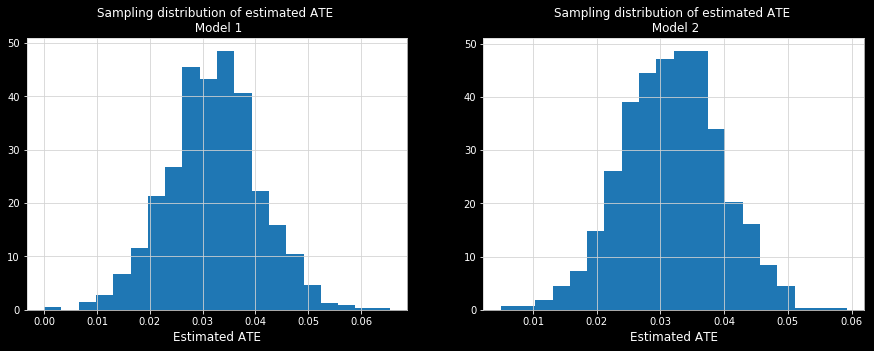

In [127]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
Repeated_sampling_results_Model1['Estimated coefficient of d'].hist(bins = 20, density=True, ax =ax[0])
ax[0].set_xlabel("Estimated ATE", fontsize=12, color = 'white')
ax[0].set_title("Sampling distribution of estimated ATE \n Model 1", color='white')

Repeated_sampling_results_Model2['Estimated coefficient of d'].hist(bins = 20, density=True, ax =ax[1])
ax[1].set_xlabel("Estimated ATE", fontsize=12, color = 'white')
ax[1].set_title("Sampling distribution of estimated ATE \n Model 2", color='white')

# 1.2

# 1.

In [131]:
def gen_shoe_data(N, block=False, person_variability=5):

  # Make N people each with their own randomly wear rate in [0, person_variability].
  people = np.arange(0, N)
  r_person = np.random.uniform(0, person_variability, size=N)
  
  # Make left and right feet
  df_left = pd.DataFrame({'i': people})
  df_left['left_foot'] = 1
  df_right = pd.DataFrame({'i': people})
  df_right['left_foot'] = 0 
  df = pd.concat([df_left, df_right], axis=0)
  df['shoe'] = np.arange(0, df.shape[0])
  
  # Each of the person's feet will have the same Y0 (success probability)
  df['r_y0'] = r_person[df['i']]
  
  # Treatment reduces wear rate by 0.20
  ATE = -0.20
  # Y outcomes are measures of shoe wear
  Y0 = np.random.normal(loc=df['r_y0'])
  Y1 = np.random.normal(loc=df['r_y0'] + ATE)
  df['y0'] = Y0
  df['y1'] = Y1
  
  P_treatment = 0.5
  if block == False:
    treatment_shoes = np.random.choice(df['shoe'], int(len(df['shoe']) * P_treatment), replace=False)
    df['d'] = df['shoe'].isin(treatment_shoes).astype('float')
  else:
    # Treat left foot only
    # In real life we would treat a random foot.
    # Wouldn't do this in real life but it doesn't matter for the simulation.
    df['d'] = df['left_foot']
         
  df['y'] = df.eval("y1 * d + y0 * (1 - d)")
  del df['y0']
  del df['y1']
  return df

def estimate_ate(df):
  means = df.groupby('d')['y'].mean()
  return {'estimated_ate': means[1] - means[0]}


def regression_ate(df, formula="y ~ d + r_y0"):
  r = sfa.ols(formula, df).fit()
  return {
      'estimated_ate': r.params['d'],
      'estimated_ate_se': r.bse['d']
  }

In [132]:
# Generate simulated data sets without blocking and with blocking
B = 500
inter_person_variability = 5
# Generate simulated data sets without blocking and with blocking
noblock = [gen_shoe_data(100, False, inter_person_variability) 
      for _ in tqdm_notebook(np.arange(0, B))]
block = [gen_shoe_data(100, True, inter_person_variability) for _ in tqdm_notebook(np.arange(0, B))]
# Estimate the ATE of each data set
m_noblock = pd.DataFrame([estimate_ate(d) for d in tqdm_notebook(noblock)])
m_block = pd.DataFrame([estimate_ate(d) for d in tqdm_notebook(block)])
# Show results
results = pd.concat([
    m_noblock['estimated_ate'].describe(),
    m_block['estimated_ate'].describe()
], axis=1)
results.columns = ['noblock', 'block']
results

,noblock,block
count,500.000000,500.000000
mean,-0.204486,-0.198667
std,0.239379,0.141177
min,-0.848753,-0.658208
25%,-0.365802,-0.296020
50%,-0.210571,-0.195772
75%,-0.051753,-0.094184
max,0.497206,0.200633


# 3.

In [143]:
# Generate simulated data sets without blocking and with blocking
B = 500
inter_person_variability = [0, 1, 5, 10, 20]

noblock_std = []
block_std = []

for i in inter_person_variability:
    # Generate simulated data sets without blocking and with blocking
    noblock = [gen_shoe_data(100, False, i) 
          for _ in tqdm_notebook(np.arange(0, B))]
    block = [gen_shoe_data(100, True, i) for _ in tqdm_notebook(np.arange(0, B))]
    # Estimate the ATE of each data set
    m_noblock = pd.DataFrame([estimate_ate(d) for d in tqdm_notebook(noblock)])
    m_block = pd.DataFrame([estimate_ate(d) for d in tqdm_notebook(block)])
    # Show results
    results = pd.concat([
        m_noblock['estimated_ate'].describe(),
        m_block['estimated_ate'].describe()
    ], axis=1)
    results.columns = ['noblock', 'block']
    noblock_std.append(results.loc['std'][0])
    block_std.append(results.loc['std'][1])
    


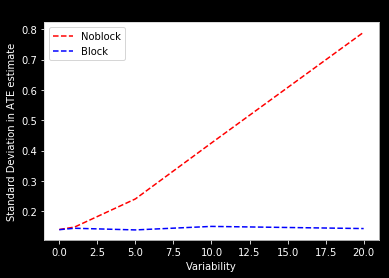

In [149]:
plt.plot(inter_person_variability, noblock_std, 'r--',label ='Noblock')
plt.plot(inter_person_variability, block_std, 'b--',label = 'Block')
plt.title('title')
plt.ylabel('Standard Deviation in ATE estimate')
plt.xlabel('Variability')
plt.legend()
plt.show()

# 5.

In [150]:
# Generate simulated data sets without blocking and with blocking
B = 500
inter_person_variability = 20
# Generate simulated data sets without blocking and with blocking
noblock = [gen_shoe_data(100, False, inter_person_variability) 
      for _ in tqdm_notebook(np.arange(0, B))]
block = [gen_shoe_data(100, True, inter_person_variability) for _ in tqdm_notebook(np.arange(0, B))]
# Estimate the ATE of each data set
m_noblock = pd.DataFrame([regression_ate(d) for d in tqdm_notebook(noblock)])
m_block = pd.DataFrame([regression_ate(d) for d in tqdm_notebook(block)])
# Show results
results = pd.concat([
    m_noblock['estimated_ate'].describe(),
    m_block['estimated_ate'].describe()
], axis=1)
results.columns = ['noblock', 'block']
results

,noblock,block
count,500.000000,500.000000
mean,-0.193435,-0.188138
std,0.147357,0.146925
min,-0.643983,-0.568360
25%,-0.295718,-0.292733
50%,-0.195516,-0.185138
75%,-0.105597,-0.080748
max,0.231895,0.214301


In [153]:
m_noblock = pd.DataFrame([estimate_ate(d) for d in tqdm_notebook(noblock)])
m_block = pd.DataFrame([estimate_ate(d) for d in tqdm_notebook(block)])
# Show results
results = pd.concat([
    m_noblock['estimated_ate'].describe(),
    m_block['estimated_ate'].describe()
], axis=1)
results.columns = ['noblock', 'block']
results

,noblock,block
count,500.000000,500.000000
mean,-0.115036,-0.188138
std,0.854013,0.146925
min,-2.617298,-0.568360
25%,-0.734031,-0.292733
50%,-0.101706,-0.185138
75%,0.476481,-0.080748
max,2.553068,0.214301


# 6.

Change score = Actual wear rate - historical wear rate
ATE  = Average change score(Treatment) - Average change score(Control) 

In [187]:
def gen_shoe_data(N, block=False, person_variability=5):

  # Make N people each with their own randomly wear rate in [0, person_variability].
  people = np.arange(0, N)
  r_person = np.random.uniform(0, person_variability, size=N)
  # Make left and right feet
  df_left = pd.DataFrame({'i': people})
  df_left['left_foot'] = 1
  df_right = pd.DataFrame({'i': people})
  df_right['left_foot'] = 0 
  df = pd.concat([df_left, df_right], axis=0)
  df['shoe'] = np.arange(0, df.shape[0])
  
  # Each of the person's feet will have the same Y0 (success probability)
  df['r_y0'] = r_person[df['i']]
  # Treatment reduces wear rate by 0.20
  ATE = -0.20
  # Y outcomes are measures of shoe wear
  Y0 = np.random.normal(loc=df['r_y0'])
  Y0_hist = np.random.normal(loc=df['r_y0'])
  Y1 = np.random.normal(loc=df['r_y0'] + ATE)
  df['y0'] = Y0
  df['y1'] = Y1
  df['y0_hist'] = Y0_hist
  P_treatment = 0.5
  if block == False:
    treatment_shoes = np.random.choice(df['shoe'], int(len(df['shoe']) * P_treatment), replace=False)
    df['d'] = df['shoe'].isin(treatment_shoes).astype('float')
  else:
    # Treat left foot only
    # In real life we would treat a random foot.
    # Wouldn't do this in real life but it doesn't matter for the simulation.
    df['d'] = df['left_foot']
         
  df['y'] = df.eval("y1 * d + y0 * (1 - d)")
  del df['y0']
  del df['y1']
  return df

def estimate_ate(df):
  means = df.groupby('d')['y'].mean()
  return {'estimated_ate': means[1] - means[0]}


def regression_ate(df, formula="y ~ d + r_y0"):
  r = sfa.ols(formula, df).fit()
  return {
      'estimated_ate': r.params['d'],
      'estimated_ate_se': r.bse['d']
  }

In [188]:
# Generate simulated data sets without blocking and with blocking
B = 500
inter_person_variability = 20
# Generate simulated data sets without blocking and with blocking
noblock = [gen_shoe_data(100, False, inter_person_variability) 
      for _ in tqdm_notebook(np.arange(0, B))]
block = [gen_shoe_data(100, True, inter_person_variability) for _ in tqdm_notebook(np.arange(0, B))]


In [189]:
# Estimate the ATE of each data set
def change_score_ATE(df):
    df['change_score'] = df['y'] - df['y0_hist']
    means = df.groupby('d')['change_score'].mean()
    return {'estimated_ate': means[1] - means[0]}

m_noblock = pd.DataFrame([change_score_ATE(d) for d in tqdm_notebook(noblock)])
m_block = pd.DataFrame([change_score_ATE(d) for d in tqdm_notebook(block)])
# Show results
results = pd.concat([
    m_noblock['estimated_ate'].describe(),
    m_block['estimated_ate'].describe()
], axis=1)
results.columns = ['noblock', 'block']
results

,noblock,block
count,500.000000,500.000000
mean,-0.201715,-0.204279
std,0.208575,0.195372
min,-0.708105,-0.683065
25%,-0.340564,-0.334003
50%,-0.195671,-0.197233
75%,-0.057213,-0.067955
max,0.468139,0.389933


# 7.

In [169]:

def gen_shoe_data_x(N, block=False, person_variability=5):

    # Make N people each with their own randomly wear rate in [0, person_variability].
    people = np.arange(0, N)
    r_person = np.random.uniform(0, person_variability, size=N)
  
    # Make left and right feet
    df_left = pd.DataFrame({'i': people})
    df_left['left_foot'] = 1
    df_right = pd.DataFrame({'i': people})
    df_right['left_foot'] = 0 
    df = pd.concat([df_left, df_right]*5, axis=0)
    df['shoe'] = np.arange(0, df.shape[0])

    # Each of the person's feet will have the same Y0 (success probability)
    df['r_y0'] = r_person[df['i']]

    # Treatment reduces wear rate by 0.20
    ATE = -0.20
    # Y outcomes are measures of shoe wear
    Y0 = np.random.normal(loc=df['r_y0'])
    Y1 = np.random.normal(loc=df['r_y0'] + ATE)
    df['y0'] = Y0
    df['y1'] = Y1

    P_treatment = 0.5
    if block == False:
        treatment_shoes = np.random.choice(df['shoe'], int(len(df['shoe']) * P_treatment), replace=False)
        df['d'] = df['shoe'].isin(treatment_shoes).astype('float')
    else:
        # Treat left foot only
        # In real life we would treat a random foot.
        # Wouldn't do this in real life but it doesn't matter for the simulation.
        df['d'] = df['left_foot']

    df['y'] = df.eval("y1 * d + y0 * (1 - d)")
    del df['y0']
    del df['y1']
    return df

def estimate_ate(df):
    means = df.groupby('d')['y'].mean()
    return {'estimated_ate': means[1] - means[0]}


def regression_ate(df, formula="y ~ d + r_y0"):
    r = sfa.ols(formula, df).fit()
    return {
      'estimated_ate': r.params['d'],
      'estimated_ate_se': r.bse['d']
  }



In [170]:
# Generate simulated data sets without blocking and with blocking
B = 500
inter_person_variability = 20
# Generate simulated data sets without blocking and with blocking
noblock = [gen_shoe_data_x(20, False, inter_person_variability) 
      for _ in tqdm_notebook(np.arange(0, B))]
block = [gen_shoe_data_x(20, True, inter_person_variability) for _ in tqdm_notebook(np.arange(0, B))]
# Estimate the ATE of each data set

m_noblock = pd.DataFrame([regression_ate(d, "y~d+C(i)") for d in tqdm_notebook(noblock)])
m_block = pd.DataFrame([regression_ate(d, "y~d+C(i)") for d in tqdm_notebook(block)])

# Show results
results = pd.concat([
    m_noblock['estimated_ate'].describe(),
    m_block['estimated_ate'].describe()
], axis=1)
results.columns = ['noblock', 'block']
results

,noblock,block
count,500.000000,500.000000
mean,-0.204298,-0.192497
std,0.154098,0.135601
min,-0.691851,-0.599093
25%,-0.306842,-0.285514
50%,-0.200444,-0.197683
75%,-0.097968,-0.104501
max,0.270877,0.165247


# 2. Regression (30 points)

# 1.

In [267]:
# This cell contains the "data-generating process."
# We will make it up, but try to create something close to
# what we saw in the Karlan experiment above.
# That will help us get a better sense of how the regression is behaving.

# Set the same size like the real data.
N = 13560

# Our "control variable" will be an indicator for graduating from high-school.
grad_high_school = np.random.binomial(n=1, p=0.5, size=N)
beta_hs = 0.1


# Set the data-generating process to have on average
# 61% of people in the treatment group, like in the paper.
# Set the ATE to be 0.032, similar to what we see in the real data.
D = np.random.binomial(n=1, p=0.61, size=N)
ATE = 0.032

# Generate the potential outcomes.
# We have to be careful tha the probabilities remain in the valid
# range [0, 1] or else we will get an error.
baseline_probability = 0.25 + beta_hs * grad_high_school
Y0 = np.random.binomial(n=1, p=baseline_probability)
Y1 = np.random.binomial(n=1, p=baseline_probability + ATE * D)

df = pd.DataFrame({
    'grad_high_school': grad_high_school,
    'd': D,
    'y0': Y0,
    'y1': Y1
})
df['y'] = df.eval("y1 * d + y0 * (1 - d)")
print(df.mean())

grad_high_school    0.499926
d                   0.609292
y0                  0.298009
y1                  0.310841
y                   0.315118
dtype: float64


In [268]:
# This cells fits two different models. 
# One model has the control variable and the other doesn't.

# We call this model a bivariate one
# because it is just a relationship between two variables.
r_sim_biv = sfa.ols("y ~ d", df).fit(cov_type='HC1')

# This model is more complex because it has an additional covariate
# (aka control variable).
r_sim_control = sfa.ols("y ~ d + grad_high_school", df).fit(cov_type='HC1')


info_dict={'R-squared' : lambda x: f"{x.rsquared:0.4f}",
           'No. coefficients': lambda x: f"{x.params.shape[0]}"}

results_table = summary_col(results=[r_sim_biv, r_sim_control],
                            float_format='%0.4f',
                            stars = True,
                            model_names=[
                                'Model 1',
                                'Model 2',
                            ],
                            info_dict=info_dict,
                            regressor_order=['d', 'grad_high_school'],
                            drop_omitted=True)

print(results_table)


                  Model 1   Model 2 
------------------------------------
d                0.0259*** 0.0268***
                 (0.0081)  (0.0081) 
grad_high_school           0.0872***
                           (0.0079) 
R-squared        0.0007    0.0096   
No. coefficients 2         3        
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# 2.

In [308]:
def Model_fit(N = 13560, beta_hs = 0.35, ATE = 0.018):
    params = locals().copy()
  # Set the same size like the real data.

    # Our "control variable" will be an indicator for graduating from high-school.
    grad_high_school = np.random.binomial(n=1, p=0.5, size=N)
    


    # Set the data-generating process to have on average
    # 61% of people in the treatment group, like in the paper.
    # Set the ATE to be 0.032, similar to what we see in the real data.
    D = np.random.binomial(n=1, p=0.61, size=N)
    
    # Generate the potential outcomes.
    # We have to be careful tha the probabilities remain in the valid
    # range [0, 1] or else we will get an error.
    baseline_probability = 0.25 + beta_hs * grad_high_school
    Y0 = np.random.binomial(n=1, p=baseline_probability)
    Y1 = np.random.binomial(n=1, p=baseline_probability + ATE * D)

    df = pd.DataFrame({
    'grad_high_school': grad_high_school,
    'd': D,
    'y0': Y0,
    'y1': Y1
    })
    df['y'] = df.eval("y1 * d + y0 * (1 - d)")
    
    # This cells fits two different models. 
    # One model has the control variable and the other doesn't.

    # We call this model a bivariate one
    # because it is just a relationship between two variables.
    Model1 = sfa.ols("y ~ d", df).fit()
    
    Model2 = sfa.ols("y ~ d + grad_high_school", df).fit()
    
    
    results_table = [dict({
      'Estimated coefficient of d': (result_reg.params['d']),
      'Standard Error in d': (result_reg.bse['d']),
      'P value': (result_reg.pvalues['d'])}, **params) for result_reg in (Model1, Model2)]
    

    return results_table



In [309]:
B = 1000
alpha = 0.05
Model1_power = np.mean([1 if Model_fit(N=N)[0]['P value'] < alpha else 0 for _ in tqdm_notebook(np.arange(0, B))])
Model2_power = np.mean([1 if Model_fit(N=N)[1]['P value'] < alpha else 0 for _ in tqdm_notebook(np.arange(0, B))])

In [315]:
print(' Model1 Power {} \n Model2 Power {}'.format(Model1_power, Model2_power))

 Model1 Power 0.562 
 Model2 Power 0.608


# 3.

In [316]:
B = 1000
alpha = 0.05
Model1_power = np.mean([1 if Model_fit(beta_hs = 0.1)[0]['P value'] < alpha else 0 for _ in tqdm_notebook(np.arange(0, B))])
Model2_power = np.mean([1 if Model_fit(beta_hs = 0.1)[1]['P value'] < alpha else 0 for _ in tqdm_notebook(np.arange(0, B))])

In [319]:
print(' Model1 Power {} \n Model2 Power {}'.format(Model1_power, Model2_power))

 Model1 Power 0.624 
 Model2 Power 0.568


# 4.

In [333]:
def Model_fit(N = 13560, beta_hs = 0.35, ATE = 0.018):
    params = locals().copy()
  # Set the same size like the real data.

    # Our "control variable" will be an indicator for graduating from high-school.
    grad_high_school = np.random.binomial(n=1, p=0.5, size=N)
    


    # Set the data-generating process to have on average
    # 61% of people in the treatment group, like in the paper.
    # Set the ATE to be 0.032, similar to what we see in the real data.
    D = np.random.binomial(n=1, p=0.61, size=N)
    
    # Generate the potential outcomes.
    # We have to be careful tha the probabilities remain in the valid
    # range [0, 1] or else we will get an error.
    baseline_probability = 0.25 + beta_hs * grad_high_school
    Y0 = np.random.binomial(n=1, p=baseline_probability)
    Y1 = np.random.binomial(n=1, p=baseline_probability + ATE * D)

    df = pd.DataFrame({
    'grad_high_school': grad_high_school,
    'd': D,
    'y0': Y0,
    'y1': Y1
    })
    df['y'] = df.eval("y1 * d + y0 * (1 - d)")
    return df.describe()

In [338]:
Model_fit(beta_hs = 0.35).loc['mean']

grad_high_school    0.501475
d                   0.616519
y0                  0.421460
y1                  0.443068
y                   0.437684
Name: mean, dtype: float64

In [339]:
Model_fit(beta_hs = 0.1).loc['mean']

grad_high_school    0.503392
d                   0.609587
y0                  0.301327
y1                  0.308776
y                   0.309956
Name: mean, dtype: float64

In [340]:
Model_fit(beta_hs = 0).loc['mean']

grad_high_school    0.502286
d                   0.610841
y0                  0.256637
y1                  0.258776
y                   0.263569
Name: mean, dtype: float64

# 3. Shoe tech experiment redux (20 points)

# 1.

In [341]:

def gen_shoe_data(N, block=False, person_variability=20):

  # Make N people each with their own randomly wear rate in [0, person_variability].
  people = np.arange(0, N)
  r_person = np.random.uniform(0, person_variability, size=N)
  
  # Make left and right feet
  df_left = pd.DataFrame({'i': people})
  df_left['left_foot'] = 1
  df_right = pd.DataFrame({'i': people})
  df_right['left_foot'] = 0 
  df = pd.concat([df_left, df_right], axis=0)
  df['shoe'] = np.arange(0, df.shape[0])
  
  # Each of the person's feet will have the same Y0 (success probability)
  df['r_y0'] = r_person[np.array(df['i'])]
  
  # Treatment reduces wear rate by 0.20
  ATE = -0.20
  # Y outcomes are measures of shoe wear
  Y0 = np.random.normal(loc=df['r_y0'])
  Y1 = np.random.normal(loc=df['r_y0'] + ATE)
  df['y0'] = Y0
  df['y1'] = Y1
  
  P_treatment = 0.5
  if block == False:
    treatment_shoes = np.random.choice(df['shoe'], int(len(df['shoe']) * P_treatment), replace=False)
    df['d'] = df['shoe'].isin(treatment_shoes).astype('float')
  else:
    # Treat left foot only
    # In real life we would treat a random foot.
    # Wouldn't do this in real life but it doesn't matter for the simulation.
    df['d'] = df['left_foot']
         
  df['y'] = df.eval("y1 * d + y0 * (1 - d)")
  del df['y0']
  del df['y1']
  return df

def estimate_ate(df):
  means = df.groupby('d')['y'].mean()
  return {'estimated_ate': means[1] - means[0]}


def regression_ate(df, formula="y ~ d + r_y0"):
  r = sfa.ols(formula, df).fit()
  return {
      'estimated_ate': r.params['d'],
      'estimated_ate_se': r.bse['d'],
      'p_values' : r.pvalues['d']
  }


In [356]:
# Generate simulated data sets without blocking and with blocking
B = 500
N = 100
alpha = 0.05
inter_person_variability = 20
# Generate simulated data sets without blocking and with blocking

noblock = [gen_shoe_data(N, False, inter_person_variability) for _ in tqdm_notebook(np.arange(0, B))]

block = [gen_shoe_data(N, True, inter_person_variability) for _ in tqdm_notebook(np.arange(0, B))]


m_block_power_without_control = np.mean([1 if regression_ate(d, formula = "y ~ d")['p_values']  < alpha else 0 for d in tqdm_notebook(block)])
m_noblock_power_without_control = np.mean([1 if regression_ate(d, formula = "y ~ d")['p_values'] < alpha else 0 for d in tqdm_notebook(noblock)])

m_block_power_with_control = np.mean([1 if regression_ate(d, formula="y ~ d + r_y0")['p_values']  < alpha else 0 for d in tqdm_notebook(block)])
m_noblock_power_with_control = np.mean([1 if regression_ate(d, formula="y ~ d + r_y0")['p_values'] < alpha else 0 for d in tqdm_notebook(noblock)])


In [362]:
print('With Control: Power of blocking is {} and nonblocking is {}'.format(m_block_power_with_control,m_noblock_power_with_control))

With Control: Power of blocking is 0.308 and nonblocking is 0.282


In [361]:
print('Without Control: Power of blocking is {} and nonblocking is {}'.format(m_block_power_without_control,m_noblock_power_without_control))

Without Control: Power of blocking is 0.0 and nonblocking is 0.048


# 4.

In [381]:
def gen_shoe_data(N = 100, block=False, person_variability=20):

  # Make N people each with their own randomly wear rate in [0, person_variability].
  people = np.arange(0, N)
  r_person = np.random.uniform(0, person_variability, size=N)
  # Make left and right feet
  df_left = pd.DataFrame({'i': people})
  df_left['left_foot'] = 1
  df_right = pd.DataFrame({'i': people})
  df_right['left_foot'] = 0 
  df = pd.concat([df_left, df_right], axis=0)
  df['shoe'] = np.arange(0, df.shape[0])
  
  # Each of the person's feet will have the same Y0 (success probability)
  df['r_y0'] = r_person[df['i']]
  # Treatment reduces wear rate by 0.20
  ATE = -0.20
  # Y outcomes are measures of shoe wear
  Y0 = np.random.normal(loc=df['r_y0'])
  Y0_hist = np.random.normal(loc=df['r_y0'])
  Y1 = np.random.normal(loc=df['r_y0'] + ATE)
  df['y0'] = Y0
  df['y1'] = Y1
  df['y0_hist'] = Y0_hist
  P_treatment = 0.5
  if block == False:
    treatment_shoes = np.random.choice(df['shoe'], int(len(df['shoe']) * P_treatment), replace=False)
    df['d'] = df['shoe'].isin(treatment_shoes).astype('float')
  else:
    # Treat left foot only
    # In real life we would treat a random foot.
    # Wouldn't do this in real life but it doesn't matter for the simulation.
    df['d'] = df['left_foot']
         
  df['y'] = df.eval("y1 * d + y0 * (1 - d)")
  del df['y0']
  del df['y1']
  return df



In [383]:
# Estimate the ATE of each data set
from scipy import stats
def tttest(df):
    df['change_score'] = df['y'] - df['y0_hist']
    p_value = stats.ttest_ind(df['change_score'][df['d'] == 1], df['change_score'][df['d'] == 0]).pvalue
    return p_value

B = 500

noblock = [gen_shoe_data(100, False, 20) for _ in tqdm_notebook(np.arange(0, B))]

block = [gen_shoe_data(100, True, 20) for _ in tqdm_notebook(np.arange(0, B))]

m_noblock_power = np.mean([1 if tttest(d) < 0.05 else 0 for d in tqdm_notebook(noblock)])
m_block_power = np.mean([1 if tttest(d) < 0.05 else 0 for d in tqdm_notebook(block)])

print('With change score: Power of blocking is {} and nonblocking is {}'.format(m_block_power, m_noblock_power))

With change score: Power of blocking is 0.178 and nonblocking is 0.146


# BONUS QUESTION:

In [399]:
#Bonus
def gen_shoe_data(N, block=False, person_variability=20):

  # Make N people each with their own randomly wear rate in [0, person_variability].
  people = np.arange(0, N)
  r_person = np.random.uniform(0, person_variability, size=N)
  
  # Make left and right feet
  df_left = pd.DataFrame({'i': people})
  df_left['left_foot'] = 1
  df_right = pd.DataFrame({'i': people})
  df_right['left_foot'] = 0 
  df = pd.concat([df_left, df_right], axis=0)
  df['shoe'] = np.arange(0, df.shape[0])
  
  # Each of the person's feet will have the same Y0 (success probability)
  df['r_y0'] = r_person[np.array(df['i'])]
  
  # Treatment reduces wear rate by 0.20
  ATE = -0.20
  # Y outcomes are measures of shoe wear
  Y0 = np.random.normal(loc=df['r_y0'])
  Y1 = np.random.normal(loc=df['r_y0'] + ATE)
  df['y0'] = Y0
  df['y1'] = Y1
  
  P_treatment = 0.5
  if block == False:
    treatment_shoes = np.random.choice(df['shoe'], int(len(df['shoe']) * P_treatment), replace=False)
    df['d'] = df['shoe'].isin(treatment_shoes).astype('float')
  else:
    # Treat left foot only
    # In real life we would treat a random foot.
    # Wouldn't do this in real life but it doesn't matter for the simulation.
    df['d'] = df['left_foot']
         
  df['y'] = df.eval("y1 * d + y0 * (1 - d)")
  del df['y0']
  del df['y1']
  return df

def estimate_ate(df):
  means = df.groupby('d')['y'].mean()
  return {'estimated_ate': means[1] - means[0]}


def regression_ate(df, formula="y ~ d + r_y0"):
  r = sfa.ols(formula, df).fit()
  return {
      'estimated_ate': r.params['d'],
      'estimated_ate_se': r.bse['d'],
      'p_values' : r.pvalues['d']
  }



In [400]:
# Generate simulated data sets without blocking and with blocking
B = 5000
inter_person_variability = 20
# Generate simulated data sets without blocking and with blocking
noblock = [gen_shoe_data(100, False, inter_person_variability) 
      for _ in tqdm_notebook(np.arange(0, B))]
block = [gen_shoe_data(100, True, inter_person_variability) for _ in tqdm_notebook(np.arange(0, B))]
# Estimate the ATE of each data set

m_block = pd.DataFrame([regression_ate(d, formula = "y ~ d") for d in tqdm_notebook(block)])
m_noblock = pd.DataFrame([regression_ate(d) for d in tqdm_notebook(noblock)])

m_block_power_without_control = np.mean([1 if regression_ate(d, formula = "y ~ d")['p_values']  < alpha else 0 for d in tqdm_notebook(block)])
m_noblock_power_without_control = np.mean([1 if regression_ate(d, formula = "y ~ d")['p_values'] < alpha else 0 for d in tqdm_notebook(noblock)])

m_block_power_with_control = np.mean([1 if regression_ate(d, formula="y ~ d + r_y0")['p_values']  < alpha else 0 for d in tqdm_notebook(block)])
m_noblock_power_with_control = np.mean([1 if regression_ate(d, formula="y ~ d + r_y0")['p_values'] < alpha else 0 for d in tqdm_notebook(noblock)])

print("( m_block_power_without_control: {} \n, m_noblock_power_without_control:{} \n, m_block_power_with_control:{} \n, m_noblock_power_with_control:{})".format(m_block_power_without_control, m_noblock_power_without_control, m_block_power_with_control, m_noblock_power_with_control))

( m_block_power_without_control: 0.0 
, m_noblock_power_without_control:0.0512 
, m_block_power_with_control:0.2884 
, m_noblock_power_with_control:0.297)


In [401]:
# Generate simulated data sets without blocking and with blocking
B = 5000
inter_person_variability = 20
# Generate simulated data sets without blocking and with blocking

noblock = [gen_shoe_data(N = 5, block=False, person_variability=20) for _ in tqdm_notebook(np.arange(0, B))]
block = [gen_shoe_data(5, True, inter_person_variability) for _ in tqdm_notebook(np.arange(0, B))]
# Estimate the ATE of each data set

m_block = pd.DataFrame([regression_ate(d, formula = "y ~ d") for d in tqdm_notebook(block)])
m_noblock = pd.DataFrame([regression_ate(d) for d in tqdm_notebook(noblock)])

# Show results
m_block_power_without_control = np.mean([1 if regression_ate(d, formula = "y ~ d")['p_values']  < alpha else 0 for d in tqdm_notebook(block)])
m_noblock_power_without_control = np.mean([1 if regression_ate(d, formula = "y ~ d")['p_values'] < alpha else 0 for d in tqdm_notebook(noblock)])

m_block_power_with_control = np.mean([1 if regression_ate(d, formula="y ~ d + r_y0")['p_values']  < alpha else 0 for d in tqdm_notebook(block)])
m_noblock_power_with_control = np.mean([1 if regression_ate(d, formula="y ~ d + r_y0")['p_values'] < alpha else 0 for d in tqdm_notebook(noblock)])

print("( m_block_power_without_control: {} \n, m_noblock_power_without_control:{} \n, m_block_power_with_control:{} \n, m_noblock_power_with_control:{})".format(m_block_power_without_control, m_noblock_power_without_control, m_block_power_with_control, m_noblock_power_with_control))

( m_block_power_without_control: 0.0002 
, m_noblock_power_without_control:0.0528 
, m_block_power_with_control:0.0628 
, m_noblock_power_with_control:0.06)
